# Mapping complaints

### Setup

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib  
import matplotlib.pyplot as plt  
from matplotlib import rcParams
import seaborn as sns

In [5]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [7]:
pd.set_option("display.max_columns",100)

### Read complaints data

In [8]:
df = pd.read_csv("data/processed/complaints.csv.gz", compression="gzip")
df.head(1)

,Unnamed: 0,from_date,from_time,to_date,to_time,offense,offense_description,occurence,premise,borough,latitude,longitude,street,number,postcode,census_tract,census_tract_code,puma
0,0,12/31/2016,23:55:00,12/31/2016,23:56:00,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE, POSSESSI",INSIDE,BUS TERMINAL,Manhattan,40.756266,-73.990501,8 AVENUE,625,10018,Clinton,MN15,3807


### Choropleth map for incidence of events per census tract

In [9]:
ct = gpd.read_file("data/raw/2000 Census Tracts.geojson")

columns = OrderedDict()
columns['boro_name'] = "borough" 
columns['geometry'] = "geometry" 
columns['ntacode'] = "census_tract_code" 
columns['ntaname'] = "census_tract" 
columns['puma'] = "puma" 

ct = ct[list(columns.keys())]
ct.columns = columns.values()

ct.head(1)

,borough,geometry,census_tract_code,census_tract,puma
0,Manhattan,(POLYGON ((-73.96432543478758 40.7563815309909...,MN19,Turtle Bay-East Midtown,3808


In [12]:
dff = df.copy()
# dff = df[df['offense'].isin(['ROBBERY', 'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT'])]
# dff = df[df['offense'].isin(['DANGEROUS DRUGS'])]


dfg = dff.groupby(['census_tract']).size().to_frame().reset_index()
dfg.columns = ['census_tract', 'incidents']
dfg.head(1)

,census_tract,incidents
0,Airport,2


In [13]:
ctg = pd.merge(ct, dfg, how='left', on=['census_tract'])
ctg.head(1)

,borough,geometry,census_tract_code,census_tract,puma,incidents
0,Manhattan,(POLYGON ((-73.96432543478758 40.7563815309909...,MN19,Turtle Bay-East Midtown,3808,2786.0


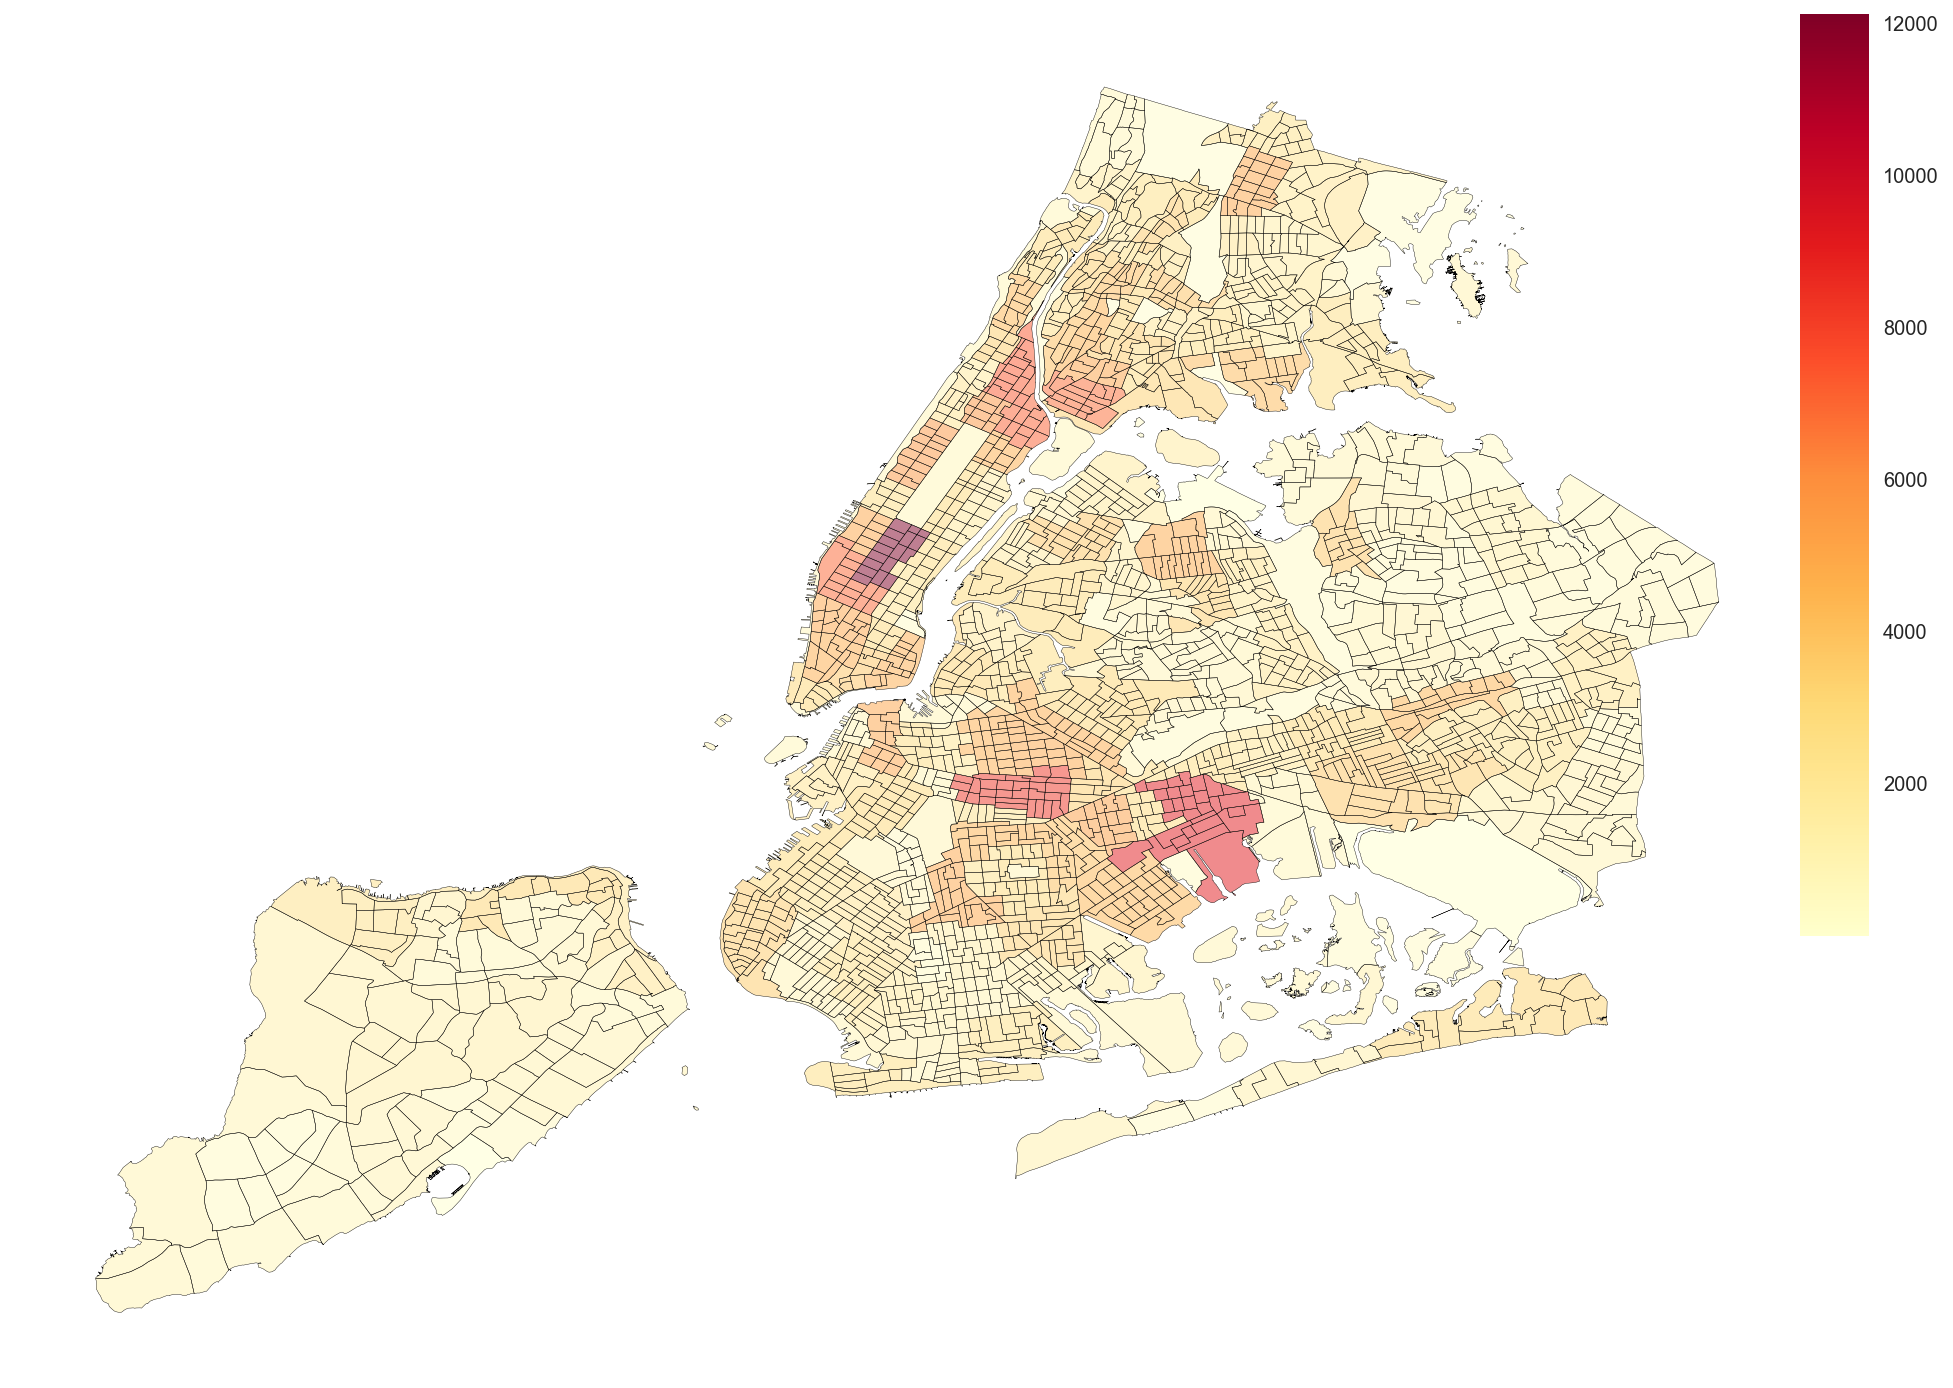

In [14]:
cmap=plt.cm.YlOrRd

ax = ctg.plot(column='incidents', cmap=cmap, figsize=(16,16), linewidth=0.2)
ax.set_facecolor('white')
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

fig = ax.get_figure()

cax = fig.add_axes([0.9, 0.4, 0.03, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=ctg.incidents.min(), vmax=ctg.incidents.max()))
sm._A = [] # fake up the array of the scalar mappable
fig.colorbar(sm, cax=cax)

### Incidents hotspot map

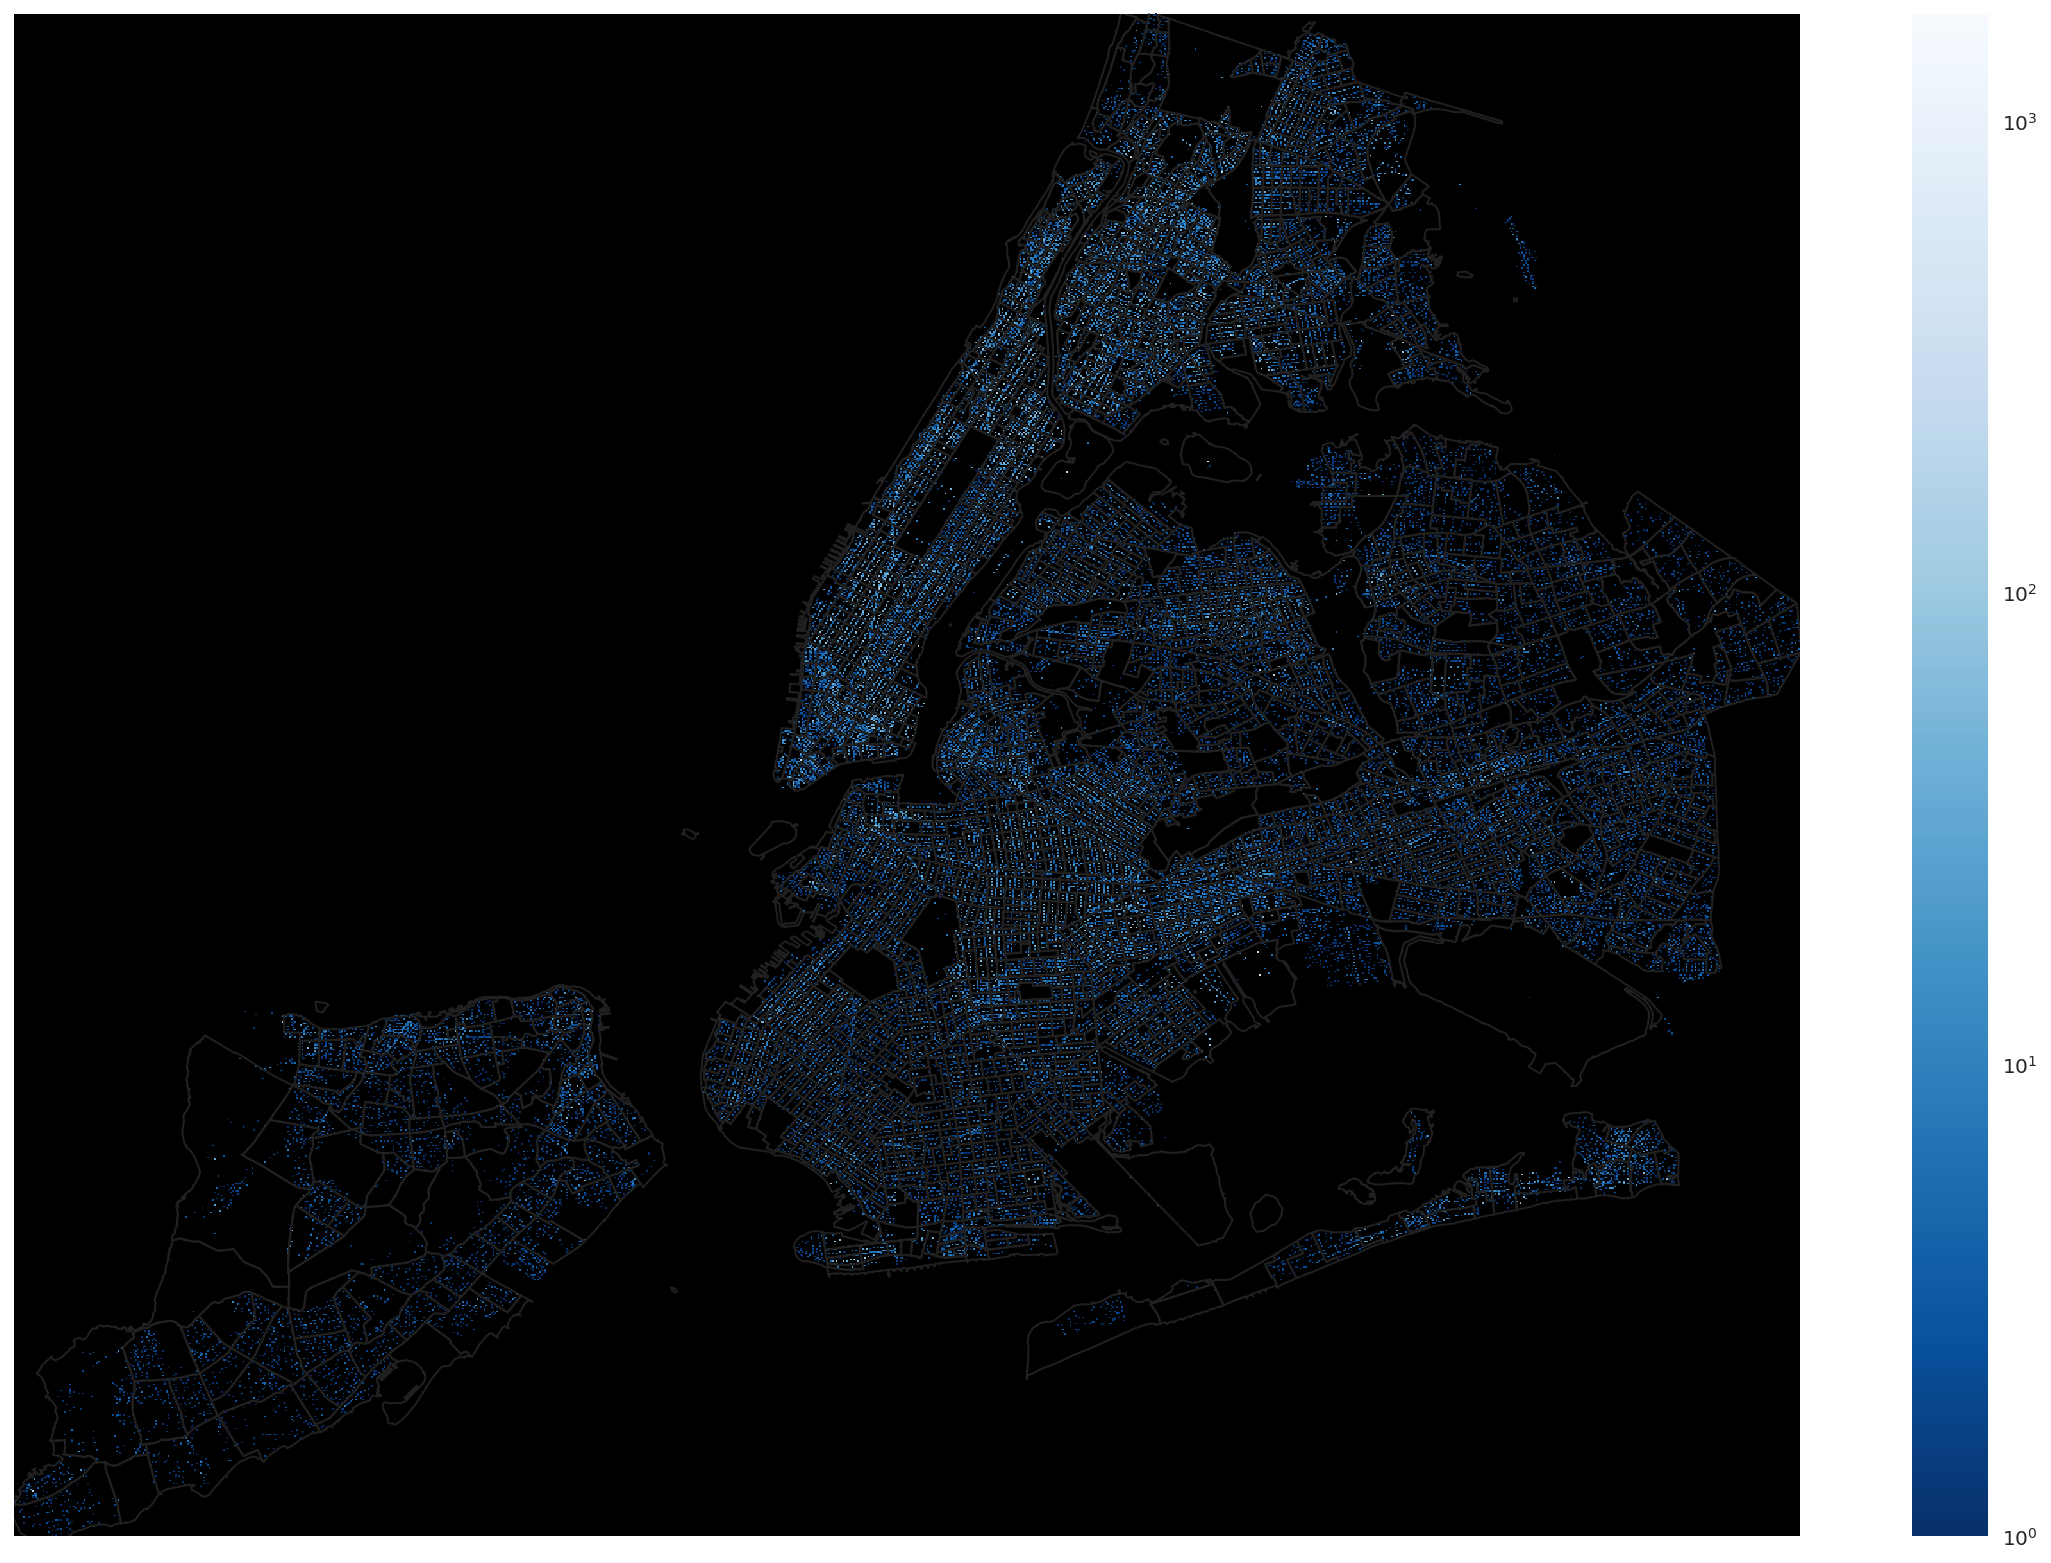

In [15]:
plt.figure(figsize=(20,14))
plt.hist2d(x=dff['longitude'].values, y=dff['latitude'].values, bins=1000, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.Blues_r)
plt.colorbar()

geo = json.loads(open("data/raw/2000 Census Tracts.geojson").read())
coord = [geo['features'][k]['geometry']['coordinates'][0] for k in range(len(geo['features']))]
for i in range(len(coord)):
    x = [v[0] for v in coord[i][0]]
    y = [v[1] for v in coord[i][0]]    
    plt.plot(x , y, '-', color="#202020", linewidth=1)

ax = plt.gca()
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_facecolor("black")